In [1]:
from os import getenv

from dotenv import load_dotenv

load_dotenv()
DATA = getenv("DATA_DIRECTORY")

In [2]:
from xml.etree import ElementTree

from scipy.io.wavfile import read

filename = "AR_A_fret_0-20"
rate, data = read(f"{DATA}/dataset2/audio/{filename}.wav")
root = ElementTree.parse(f"{DATA}/dataset2/annotation/{filename}.xml").getroot()
length = data.shape[0] / rate
signal = data / data.max()

<ipython-input-2-8481425d76a9>:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = read(f"{DATA}/dataset2/audio/{filename}.wav")


In [3]:
from numpy import abs, angle, unwrap, diff, pi, array
from scipy.signal import hilbert

onsets_real = array([float(event.find("onsetSec").text) for event in root.iter("event")])
analytic_signal = hilbert(signal)
amplitude_envelope = abs(analytic_signal)
instantaneous_phase = unwrap(angle(analytic_signal))
instantaneous_frequency = diff(instantaneous_phase) / (2 * pi)

In [4]:
from numpy import ceil, log2, exp, pi, arange, array, sqrt
from scipy.fft import fft
from scipy.signal.windows import hamming
from scipy.sparse import coo_matrix, vstack

def cqt_kern(fs, bins=12, fmin=32, fmax=84*32, window=hamming):
    K = int(ceil(bins * log2(fmax / fmin)))
    Q = 1 / (2 ** (1 / bins) - 1)
    fft_len = int(2 ** ceil(log2(ceil(Q * fs / fmin))))
    res = []
    for k in range(K, 0, -1):
        N = int(ceil(Q * fs / (fmin * 2 ** ((k - 1) / bins))))
        tmp_kernel = window(N) / N * exp(2 * pi * 1j * Q * arange(N) / N)
        spec_kern = fft(tmp_kernel, fft_len)
        spec_kern[abs(spec_kern) <= 0.05] = 0
        res += [coo_matrix(spec_kern)]
    kernel = vstack(res[::-1]).tocsc().transpose().conj() / fft_len
    return kernel

def cqt(x, fs, hop_size=512, bins=12, fmin=32, fmax=84*48, window=hamming):
    kern = cqt_kern(fs, bins, fmin, fmax, window)
    return array(range(0, len(x) - kern.shape[0], hop_size)) / fs, array([fft(x[i:i + kern.shape[0]], kern.shape[0]) * kern for i in range(0, len(x) - kern.shape[0], hop_size)])

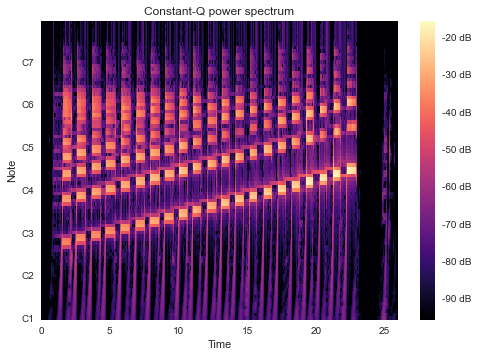

In [7]:
from librosa import amplitude_to_db
from librosa.display import specshow
from matplotlib import pyplot as plt

time_domain, spectrum = cqt(signal, rate)
spectrum = spectrum.transpose()
fig, ax = plt.subplots()
img = specshow(amplitude_to_db(abs(spectrum)), sr=rate, x_axis='time', y_axis='cqt_note', ax=ax)
ax.set_title('Constant-Q power spectrum')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

In [6]:
from librosa import hz_to_midi
from numpy import argwhere

tol = 58e-4
pitches = array([int(event.find("pitch").text) for event in root.iter("event")])
onsets = argwhere((abs(time_domain[:, None] - onsets_real) < tol).any(1))
len(onsets_real) == len(onsets)

True